In [1]:
# import modules
import math
import sys
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx

from leap_ec.individual import Individual
from leap_ec.decoder import IdentityDecoder
from leap_ec.representation import Representation
from leap_ec.algorithm import multi_population_ea
from leap_ec.context import context

import leap_ec.ops as ops
from leap_ec import probe
from leap_ec.algorithm import multi_population_ea

from leap_ec.real_rep.problems import SchwefelProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

import yfinance as yf

# Read Data

In [2]:
df = yf.download("AMZN",period = "max", interval = "1d")
df['Range'] = df['High'] - df['Low']
df['RangeOC'] = df['Open'] - df['Adj Close']
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Range,RangeOC
Date,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0.572917,0.479167
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0.270834,0.239583
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0.145833,0.052084
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0.114583,0.093750
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0.270833,0.208334


# Identify trend day and features day

In [3]:
# Up and Down trend day
df.loc[(df['Open'] <= df['Low']+0.1*df['Range']) & (df['Adj Close'] >= df['High']-0.2*df['Range']), 'Up_Trend'] = 1
df.loc[(df['Open'] >= df['High']-0.1*df['Range']) & (df['Adj Close'] <= df['High']+0.2*df['Range']), 'Down_Trend'] = 1
df['Up_Trend'] = df['Up_Trend'].fillna(0)
df['Down_Trend'] = df['Down_Trend'].fillna(0)

In [4]:
# NRk
for i in range(2,8):
    df['Previous{k}'.format(k = i)] = df['Range'].rolling(i).min().shift(i-1)
    df.loc[df['Range'] <= df['Previous{k}'.format(k = i)], 'NR{k}'.format(k = i)] = 1
    df = df.drop(['Previous{k}'.format(k = i)], axis=1)
    df['NR{k}'.format(k = i)] = df['NR{k}'.format(k = i)].fillna(0)

In [5]:
# DOJI
# TODO: What does x effect? x: a small percentage of the range
x = 0.05
df.loc[df['RangeOC'].abs() <= x*df['Range'], 'DOJI'] = 1
df['DOJI'] = df['DOJI'].fillna(0)

In [24]:
# Hook day
#for delta in range(0, 11):
delta = 0.5
df.loc[df['Open'].shift(-1) < df['Low']-delta, 'Up_Hook{d}'.format(d=delta)] = 1
df.loc[df['Open'].shift(-1) > df['High']+delta, 'Down_Hook{d}'.format(d=delta)] = 1
df['Up_Hook{d}'.format(d=delta)] = df['Up_Hook{d}'.format(d=delta)].fillna(0)
df['Down_Hook{d}'.format(d=delta)] = df['Down_Hook{d}'.format(d=delta)].fillna(0)
df[["Up_Hook0.5","Down_Hook0.5"]]

,Up_Hook0.5,Down_Hook0.5
Date,,
1997-05-15,0.0,0.0
1997-05-16,0.0,0.0
1997-05-19,0.0,0.0
1997-05-20,0.0,0.0
1997-05-21,0.0,0.0
...,...,...
2021-03-08,0.0,0.0
2021-03-09,0.0,1.0
2021-03-10,0.0,0.0


# Features day membership functions

In [7]:
# NRk membership function
ks = [4,6,7]
cs = [1/2,1/3,1/3]
v_mins = [2,3,4]
v_maxs = [4,6,7]

for i in range(0,len(ks)):
    # Generate other parameters in the function
    df['D{k}'.format(k = ks[i])] = df['NR{k}'.format(k = ks[i])].shift(1).rolling(ks[i]).sum()
    df['~R{k}'.format(k = ks[i])] = df['Range'].shift(1).rolling(ks[i]).max()
    df['eta{k}'.format(k = ks[i])] = (df['~R{k}'.format(k = ks[i])]-df['Range'])/df['~R{k}'.format(k = ks[i])]
    df['NR_x{k}'.format(k = ks[i])] = df['D{k}'.format(k = ks[i])] + df['eta{k}'.format(k = ks[i])]
    # Conditioinal membership function
    df.loc[df['NR_x{k}'.format(k = ks[i])] < v_mins[i], 'NR{k}_membership'.format(k = ks[i])] = 0
    df.loc[(df['NR_x{k}'.format(k = ks[i])] >= v_mins[i]) & (df['NR_x{k}'.format(k = ks[i])] < v_maxs[i]), 
           'NR{k}_membership'.format(k = ks[i])] = cs[i]*(df['NR_x{k}'.format(k = ks[i])] - v_mins[i])
    df.loc[df['NR_x{k}'.format(k = ks[i])] >= v_maxs[i], 'NR{k}_membership'.format(k = ks[i])] = 1
    # Drop unecessary columns
    df = df.drop(['D{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['~R{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['eta{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['NR_x{k}'.format(k = ks[i])], axis=1)
    
#df[['Range','NR4','D4','~R4','eta4','NR_x4']].tail(10)
#df[df['NR4_membership'] != 0]

<AxesSubplot:xlabel='Date'>

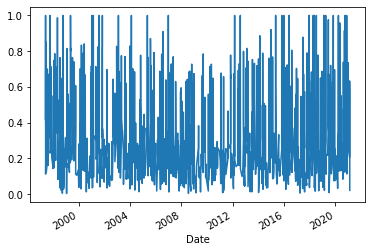

In [8]:
df[df['NR4_membership'] != 0]['NR4_membership'].plot()

<AxesSubplot:xlabel='Date'>

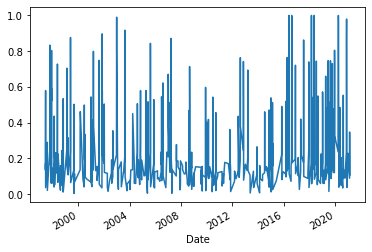

In [9]:
df[df['NR6_membership'] != 0]['NR6_membership'].plot()

<AxesSubplot:xlabel='Date'>

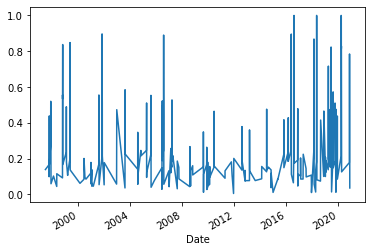

In [10]:
df[df['NR7_membership'] != 0]['NR7_membership'].plot()

In [11]:
# DOJI membership function
rhos = [0.05,0.10,0.15,0.20,0.25,0.30]
for rho in rhos:
    df.loc[(df['RangeOC'] >= 0) & (df['RangeOC']<= 2), 'DOJI{r}'.format(r = rho) ] = 1 - (df['RangeOC']/rho)
    df['DOJI{r}_membership'.format(r = rho)] = df['DOJI{r}'.format(r = rho)].fillna(0)

In [25]:
# Hook day membership function
#for delta in range(0, 11):
delta = 0.5
# Generate other parameters in the function
df.loc[(df['Up_Hook{d}'.format(d=delta)] == 1), 'Hook{d}_x'.format(d=delta)] = df['Low']-delta-df['Open'].shift(1)
df.loc[(df['Down_Hook{d}'.format(d=delta)] == 1), 'Hook{d}_x'.format(d=delta)] = df['Open'].shift(1)-delta-df['High']
df['Hook{d}_x'.format(d=delta)] = df['Hook{d}_x'.format(d=delta)].fillna(0)
# Conditioinal membership function
df.loc[(df['Hook{d}_x'.format(d=delta)] < -1/2), 'Hook{d}_membership'.format(d=delta)] = 0
df.loc[(df['Hook{d}_x'.format(d=delta)] >= -1/2) & (df['Hook{d}_x'.format(d=delta)] < 0), 
       'Hook{d}_membership'.format(d=delta)] = 2*(df['Hook{d}_x'.format(d=delta)] + 0.5)
df.loc[(df['Hook{d}_x'.format(d=delta)] >= 0), 'Hook{d}_membership'.format(d=delta)] = 1
    
#df[(df['Hook2_membership']>0)&(df['Hook2_membership']!=1)]

In [26]:
df

,Open,High,Low,Close,Adj Close,Volume,Range,RangeOC,Up_Trend,Down_Trend,...,DOJI0.15,DOJI0.15_membership,DOJI0.2,DOJI0.2_membership,DOJI0.25,DOJI0.25_membership,DOJI0.3,DOJI0.3_membership,Hook0.5_x,Hook0.5_membership
Date,,,,,,,,,,,,,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0.572917,0.479167,0.0,0.0,...,-2.194447,-2.194447,-1.395835,-1.395835,-0.916668,-0.916668,-0.597223,-0.597223,0.000000,1.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0.270834,0.239583,0.0,1.0,...,-0.597220,-0.597220,-0.197915,-0.197915,0.041668,0.041668,0.201390,0.201390,0.000000,1.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0.145833,0.052084,0.0,1.0,...,0.652774,0.652774,0.739580,0.739580,0.791664,0.791664,0.826387,0.826387,0.000000,1.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0.114583,0.093750,0.0,0.0,...,0.375000,0.375000,0.531250,0.531250,0.625000,0.625000,0.687500,0.687500,0.000000,1.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0.270833,0.208334,0.0,1.0,...,-0.388893,-0.388893,-0.041670,-0.041670,0.166664,0.166664,0.305553,0.305553,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08,3015.000000,3064.590088,2951.310059,2951.949951,2951.949951,4178500,113.280029,63.050049,0.0,0.0,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,1.0
2021-03-09,3017.989990,3090.959961,3005.149902,3062.850098,3062.850098,4023500,85.810059,-44.860107,0.0,0.0,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,-76.459961,0.0
2021-03-10,3098.449951,3116.459961,3030.050049,3057.639893,3057.639893,3008700,86.409912,40.810059,0.0,0.0,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,1.0


# Singleton fuzzifier

## Vector of fuzzy numbers A

In [33]:
A = df[["NR4_membership","NR6_membership","NR7_membership","DOJI0.1_membership","Hook0.5_membership"]]
A = A.iloc[7:]
A.to_csv("A.csv")  
A

,NR4_membership,NR6_membership,NR7_membership,DOJI0.1_membership,Hook0.5_membership
Date,,,,,
1997-05-27,0.000000,0.0,0.0,0.00000,1.0
1997-05-28,0.000000,0.0,0.0,0.06250,1.0
1997-05-29,0.000000,0.0,0.0,0.63541,1.0
1997-05-30,0.416667,0.0,0.0,1.00000,1.0
1997-06-02,0.916667,0.0,0.0,1.00000,1.0
...,...,...,...,...,...
2021-03-08,0.000000,0.0,0.0,0.00000,1.0
2021-03-09,0.000000,0.0,0.0,0.00000,0.0
2021-03-10,0.000000,0.0,0.0,0.00000,1.0


In [32]:
price = df[["Open","High","Low","Close","Adj Close"]]
price = price.iloc[7:]
price.to_csv("price.csv")  
price

,Open,High,Low,Close,Adj Close
Date,,,,,
1997-05-27,1.510417,1.645833,1.458333,1.583333,1.583333
1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250
1997-05-29,1.541667,1.541667,1.479167,1.505208,1.505208
1997-05-30,1.500000,1.510417,1.479167,1.500000,1.500000
1997-06-02,1.510417,1.531250,1.500000,1.510417,1.510417
...,...,...,...,...,...
2021-03-08,3015.000000,3064.590088,2951.310059,2951.949951,2951.949951
2021-03-09,3017.989990,3090.959961,3005.149902,3062.850098,3062.850098
2021-03-10,3098.449951,3116.459961,3030.050049,3057.639893,3057.639893
